In [1]:
import numpy as np
from scipy.integrate import solve_ivp
import matplotlib.pyplot as plt
from numpy import cos
from math import log
from scipy.interpolate import interp1d
from ipywidgets import interact, interactive, fixed, interact_manual
import ipywidgets as widgets
from mpl_toolkits.mplot3d import Axes3D
from scipy.optimize import minimize_scalar
from scipy.optimize import minimize
from mpl_toolkits.mplot3d.art3d import Poly3DCollection
from sage.plot.plot3d.parametric_surface import ParametricSurface
import plotly.graph_objects as go
import plotly.express as px
from scipy.optimize import fsolve
from sympy import symbols, Eq, solve

#### Using the equations:

\begin{gather*}
\begin{cases}
\dfrac{dS_H}{dt} = -ab_2\bigg(\dfrac{I_M}{N}\bigg)S_H\\
\\
\dfrac{dI_H}{dt} = ab_2\bigg(\dfrac{I_M}{N}\bigg)S_H-\gamma I_H\\
\\
\dfrac{dR_H}{dt} = \gamma I_H\\
\\
\dfrac{dS_M}{dt} = b - ab_1\bigg(\dfrac{I_H}{N}\bigg)S_M - \mu S_M\\
\\
\dfrac{dE_M}{dt} = ab_1\bigg(\dfrac{I_H}{N}\bigg)S_M - \mu E_M - b_3E_M -lE_M\\
\\
\dfrac{dI_M}{dt} = b_3E_M -\mu I_M\\
\end{cases}
\end{gather*}

$\mathcal{R}_0$ (SIR):

$$\Big | \dfrac{ab_2}{\gamma}\Big |$$

$\mathcal{R}_0$ (SEI):

$$\Big | \dfrac{ab_1b_3}{(b_3+l+ \mu)\mu}\Big |$$

$\mathcal{R}_0$ (SIR/SEI):

$$\Big | \sqrt{\dfrac{a^2 b_1 b_2 b_3}{(b_3 +  l + \mu) \gamma \mu}}\Big |$$

In [2]:
def R0_sir(a, b2, gamma):
    return abs((a * b2) / gamma)
    
#R0_sir_curr = R0_sir(a_curr, b2, gamma)
    
def R0_sei(a, b1, b3, l, mu):
    return abs((a * b1 * b3) / ((b3 + l) * mu + mu** 2))
    
#R0_sei_curr = R0_sei(a_curr, b1, b3_curr, l_curr, mu_curr)
    
def R0_full(a, b1, b2, b3, gamma, l, mu):
    return abs(((a** 2 * b1 * b2 * b3) / (b3 * gamma * mu + gamma * l * mu + gamma * mu** 2))**(1/2))
    
#R0_curr = R0(a_curr, b1, b2, b3_curr, gamma, l_curr, mu_curr)

In [3]:
def calculate_initial_values(R_L, T_prime, Tmin, DD, D1, T1, T2, omega1, phi1, R1, R2, omega2, phi2,
                            p_ML, p_ME, p_MP, c1, c2, A, B, C, b1, b2, gamma):
    
    T0 = T1 * (1 + T2 * cos(omega1 * 0 - phi1))
    R0 = R1 * (1 + R2 * cos(omega2 * 0 - phi2))

    tau_L0 = 1 / (c1 * T0 + c2)

    p_LT0 = np.exp(-(c1 * T0 + c2))
    
    p_LR0 = (4 * p_ML / R_L**2) * R0 * (max(1e-5, R_L - R0))
    
    p_LRT0 = p_LR0 * p_LT0
    
    p_ER0 = (4 * p_ME / R_L**2) * R0 * (max(1e-5, R_L - R0))
    
    p_PR0 = (4 * p_MP / R_L**2) * R0 * (max(1e-5, R_L - R0))

    a0 = (max(1e-5, T0 - T_prime)) / D1
    b0 = B_E * p_ER0 * p_LRT0 * p_PR0 / (tau_E + tau_L0 + tau_P)

    tau_M0 = DD / (max(1e-5, T0 - Tmin))
    
    b30 =  1 / tau_M0
    
    p0 = np.exp(-1 / (A * T0**2 + B * T0 + C))
    l0 = p0 ** tau_M0

    mu0 = -log(p0)

    initial_R0_sir = R0_sir(a0, b2, gamma)
    initial_R0_sei = R0_sei(a0, b1, b30, l0, mu0)
    initial_R0_full = R0_full(a0, b1, b2, b30, gamma, l0, mu0)
    
    return initial_R0_sir, initial_R0_sei, initial_R0_full

In [4]:
T_prime=24.4

T1= 26.4 
T2= 0.025
omega1= 0.017
phi1= -1.45

R1= 250.083 
R2= 0.565
omega2= 0.02
phi2=1.6

B_E=200
p_ME=0.9
p_ML=0.25
p_MP=0.75
tau_E=1
tau_P=1
c1=0.00554
c2=-0.06737
D1=36.5
b1=0.04

A=356.3
B=15
C=-48.78

b2=0.09
tau_H=10
DD=105
Tmin=14.5
gamma=1/120
R_L=450
N=8558
M=300000  #0

E_M0=50000
I_M0=0 # None
I_H0=1000

if E_M0 is None:
        E_M0 = M / 100

S_H0 = N - I_H0
S_M0 = M - E_M0 - I_M0

In [5]:
initial_R0_sir, initial_R0_sei, initial_R0_full = calculate_initial_values(R_L, T_prime, Tmin, DD, D1, 
                                                                           T1, T2, omega1, phi1, R1, R2, omega2, phi2,
                                                                           p_ML, p_ME, p_MP, c1, c2, A, B, C, b1, b2, gamma)

In [6]:
print(f'R0 (SIR) = {initial_R0_sir} \nR0 (SEI) = {initial_R0_sei}\nR0 (Full) = {initial_R0_full}')

R0 (SIR) = 0.6153135271246742 
R0 (SEI) = 58.38703858148659
R0 (Full) = 5.993858077060129


#### Decreasing $A$:

In [7]:
A=100

In [8]:
initial_R0_sir, initial_R0_sei, initial_R0_full = calculate_initial_values(R_L, T_prime, Tmin, DD, D1, 
                                                                           T1, T2, omega1, phi1, R1, R2, omega2, phi2,
                                                                           p_ML, p_ME, p_MP, c1, c2, A, B, C, b1, b2, gamma)

In [9]:
print(f'R0 (SIR) = {initial_R0_sir} \nR0 (SEI) = {initial_R0_sei}\nR0 (Full) = {initial_R0_full}')

R0 (SIR) = 0.6153135271246742 
R0 (SEI) = 16.4467054425738
R0 (Full) = 3.1811759359473752


In [10]:
A=50

In [11]:
initial_R0_sir, initial_R0_sei, initial_R0_full = calculate_initial_values(R_L, T_prime, Tmin, DD, D1, 
                                                                           T1, T2, omega1, phi1, R1, R2, omega2, phi2,
                                                                           p_ML, p_ME, p_MP, c1, c2, A, B, C, b1, b2, gamma)

In [12]:
print(f'R0 (SIR) = {initial_R0_sir} \nR0 (SEI) = {initial_R0_sei}\nR0 (Full) = {initial_R0_full}')

R0 (SIR) = 0.6153135271246742 
R0 (SEI) = 8.264822310334955
R0 (Full) = 2.2550957777511136


In [13]:
A=25

In [14]:
initial_R0_sir, initial_R0_sei, initial_R0_full = calculate_initial_values(R_L, T_prime, Tmin, DD, D1, 
                                                                           T1, T2, omega1, phi1, R1, R2, omega2, phi2,
                                                                           p_ML, p_ME, p_MP, c1, c2, A, B, C, b1, b2, gamma)

In [15]:
print(f'R0 (SIR) = {initial_R0_sir} \nR0 (SEI) = {initial_R0_sei}\nR0 (Full) = {initial_R0_full}')

R0 (SIR) = 0.6153135271246742 
R0 (SEI) = 4.173880812245059
R0 (Full) = 1.6025745924544381


In [16]:
A=12.5

In [17]:
initial_R0_sir, initial_R0_sei, initial_R0_full = calculate_initial_values(R_L, T_prime, Tmin, DD, D1, 
                                                                           T1, T2, omega1, phi1, R1, R2, omega2, phi2,
                                                                           p_ML, p_ME, p_MP, c1, c2, A, B, C, b1, b2, gamma)

In [18]:
print(f'R0 (SIR) = {initial_R0_sir} \nR0 (SEI) = {initial_R0_sei}\nR0 (Full) = {initial_R0_full}')

R0 (SIR) = 0.6153135271246742 
R0 (SEI) = 2.128410194571681
R0 (Full) = 1.1443948549298952


#### Modifyying $T'$:

In [19]:
T_prime=25

In [20]:
initial_R0_sir, initial_R0_sei, initial_R0_full = calculate_initial_values(R_L, T_prime, Tmin, DD, D1, 
                                                                           T1, T2, omega1, phi1, R1, R2, omega2, phi2,
                                                                           p_ML, p_ME, p_MP, c1, c2, A, B, C, b1, b2, gamma)

In [21]:
print(f'R0 (SIR) = {initial_R0_sir} \nR0 (SEI) = {initial_R0_sei}\nR0 (Full) = {initial_R0_full}')

R0 (SIR) = 0.43777928054933146 
R0 (SEI) = 1.5143074914143047
R0 (Full) = 0.8142066347812559


In [22]:
T_prime=25.5

In [23]:
initial_R0_sir, initial_R0_sei, initial_R0_full = calculate_initial_values(R_L, T_prime, Tmin, DD, D1, 
                                                                           T1, T2, omega1, phi1, R1, R2, omega2, phi2,
                                                                           p_ML, p_ME, p_MP, c1, c2, A, B, C, b1, b2, gamma)

In [24]:
print(f'R0 (SIR) = {initial_R0_sir} \nR0 (SEI) = {initial_R0_sei}\nR0 (Full) = {initial_R0_full}')

R0 (SIR) = 0.2898340750698794 
R0 (SEI) = 1.0025552387831584
R0 (Full) = 0.5390497846573903


In [25]:
T_prime=24.8

In [26]:
initial_R0_sir, initial_R0_sei, initial_R0_full = calculate_initial_values(R_L, T_prime, Tmin, DD, D1, 
                                                                           T1, T2, omega1, phi1, R1, R2, omega2, phi2,
                                                                           p_ML, p_ME, p_MP, c1, c2, A, B, C, b1, b2, gamma)

In [27]:
print(f'R0 (SIR) = {initial_R0_sir} \nR0 (SEI) = {initial_R0_sei}\nR0 (Full) = {initial_R0_full}')

R0 (SIR) = 0.496957362741112 
R0 (SEI) = 1.7190083924667623
R0 (Full) = 0.9242693748308016


In [28]:
T_prime=24.4

In [29]:
initial_R0_sir, initial_R0_sei, initial_R0_full = calculate_initial_values(R_L, T_prime, Tmin, DD, D1, 
                                                                           T1, T2, omega1, phi1, R1, R2, omega2, phi2,
                                                                           p_ML, p_ME, p_MP, c1, c2, A, B, C, b1, b2, gamma)

In [30]:
print(f'R0 (SIR) = {initial_R0_sir} \nR0 (SEI) = {initial_R0_sei}\nR0 (Full) = {initial_R0_full}')

R0 (SIR) = 0.6153135271246742 
R0 (SEI) = 2.128410194571681
R0 (Full) = 1.1443948549298952


In [31]:
T_prime=25.6

In [32]:
initial_R0_sir, initial_R0_sei, initial_R0_full = calculate_initial_values(R_L, T_prime, Tmin, DD, D1, 
                                                                           T1, T2, omega1, phi1, R1, R2, omega2, phi2,
                                                                           p_ML, p_ME, p_MP, c1, c2, A, B, C, b1, b2, gamma)

In [33]:
print(f'R0 (SIR) = {initial_R0_sir} \nR0 (SEI) = {initial_R0_sei}\nR0 (Full) = {initial_R0_full}')

R0 (SIR) = 0.26024503397398857 
R0 (SEI) = 0.9002047882569278
R0 (Full) = 0.48401841463261647


In [34]:
T_prime=19.9

In [35]:
initial_R0_sir, initial_R0_sei, initial_R0_full = calculate_initial_values(R_L, T_prime, Tmin, DD, D1, 
                                                                           T1, T2, omega1, phi1, R1, R2, omega2, phi2,
                                                                           p_ML, p_ME, p_MP, c1, c2, A, B, C, b1, b2, gamma)

In [36]:
print(f'R0 (SIR) = {initial_R0_sir} \nR0 (SEI) = {initial_R0_sei}\nR0 (Full) = {initial_R0_full}')

R0 (SIR) = 1.946820376439743 
R0 (SEI) = 6.7341804682519975
R0 (Full) = 3.620806506044685


In [37]:
def b3_correction_model(t, z, T_prime, T1, T2, omega1, phi1, R1, R2, omega2, phi2,
                   B_E, p_ME, p_ML, p_MP, tau_E, tau_P, c1, c2,
                   D1, b1, A, B, C, b2, tau_H, DD, Tmin, gamma, R_L,
                   N, M, E_M0, I_H0, I_M0):
    
    S_H, I_H, R_H, S_M, E_M, I_M = z
    
    # Temperature and rain functions
    def Temp(t):
        return T1 * (1 + T2 * cos(omega1 * t - phi1))

    def Rain(t):
        return R1 * (1 + R2 * cos(omega2 * t - phi2))

    R_curr = Rain(t)
    T_curr = Temp(t)
    
    # Duration of the larval development phase
    def tau_L(Temp):
        return 1 / (c1 * Temp + c2)
    
    # Daily mosquito survival rate
    def p(Temp):
        return np.exp(-1 / (A*Temp**2 + B*Temp + C))
    
    # Probability of larval survival dependent on temperature and rain
    def p_LT(Temp):
        return np.exp(-(c1 * Temp + c2))
    
    def p_LR(Rain):
        return (4*p_ML/R_L**2) * Rain * (max(1e-5,R_L - Rain))
    
    def p_LRT(Rain,Temp):
        return p_LR(Rain)*p_LT(Temp)
    
    # Probability of survival of eggs and pupae dependent on rain
    def p_ER(Rain):
        return (4*p_ME/R_L**2) * Rain * (max(1e-5,R_L - Rain))
    
    # Probability of survival of eggs and pupae dependent on rain
    def p_PR(Rain):
        return (4*p_MP/R_L**2) * Rain * (max(1e-5,R_L - Rain))

    # Duration of the sporogonic cycle
    def tau_M(Temp):
        return DD / (max(1e-5,Temp - Tmin))
    
    tau_M_curr = tau_M(T_curr)

    # Exposed infection rate (1/Duration of the sporogonic cycle)
    def b3(tau_M, Temp):
        return 1/tau_M
    
    b3_curr = b3(tau_M_curr, T_curr)
    
    # Defining the mosquito survival function
    def l_tau_M(tau_M, Temp):  
        p_T = p(Temp)
        return p_T**tau_M
    
    l_curr = l_tau_M(tau_M_curr, T_curr)

    # Defining the mosquito mortality rate
    def mu(Temp):
        return -log(p(Temp))
    
    mu_curr = mu(T_curr)
    
    # Calculate the bite rate and transmission probability
    def a(Temp):
        return (max(1e-5, Temp - T_prime)) / D1
    
    a_curr = a(T_curr)
    
    def b(Rain,Temp):
        return B_E * p_ER(Rain) * p_LRT(Rain,Temp) * p_PR(Rain) / (tau_E + tau_L(Temp) + tau_P)
    
    b_curr = b(R_curr, T_curr)
    
    dShdt = -a_curr * b2 * (I_M / N) * S_H
    dIhdt = a_curr * b2 * (I_M / N) * S_H - gamma * I_H
    dRhdt = gamma * I_H
    
    dSmdt = b_curr - a_curr * b1 * (I_H / N) * S_M - mu_curr * S_M
    dEmdt = a_curr * b1 * (I_H / N) * S_M - mu_curr * E_M - b3_curr * E_M - l_curr * E_M
    dImdt = b3_curr * E_M - mu_curr * I_M
    
    return [dShdt, dIhdt, dRhdt, dSmdt, dEmdt, dImdt]

In [38]:
args = (T_prime, T1, T2, omega1, phi1, R1, R2, omega2, phi2,
                   B_E, p_ME, p_ML, p_MP, tau_E, tau_P, c1, c2,
                   D1, b1, A, B, C, b2, tau_H, DD, Tmin, gamma, R_L,
                   N, M, E_M0, I_H0, I_M0)

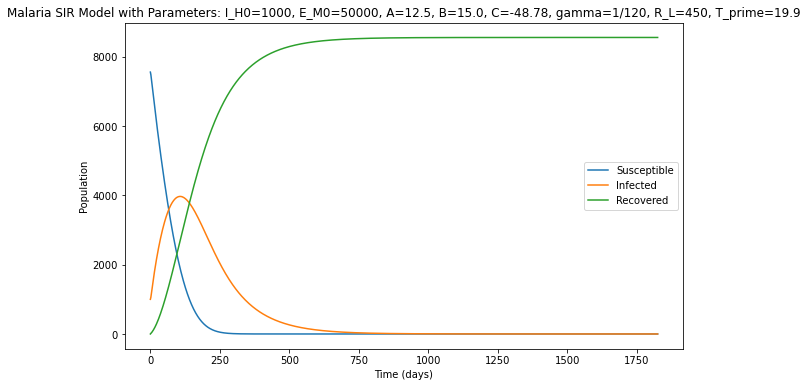

In [39]:
t_eval = np.linspace(0, 1825, 1000)  # Evaluate the solution at 1000 points between 0 and 1825
sol = solve_ivp(b3_correction_model, [0, 1825], [S_H0, I_H0, 0, S_M0, E_M0, 0], args=args, dense_output=True, t_eval=t_eval, method="DOP853")
#sol

times = sol.t
S_H, I_H, R_H, S_M, E_M, I_M = sol.y

plt.figure(figsize=(10, 6))
plt.plot(times, S_H, label='Susceptible')
plt.plot(times, I_H, label='Infected')
plt.plot(times, R_H, label='Recovered')

plt.xlabel('Time (days)')
plt.ylabel('Population')
plt.title(f'Malaria SIR Model with Parameters: I_H0={I_H0}, E_M0={E_M0}, A={round(A, 2)}, B={round(B, 2)}, C={round(C, 2)}, gamma={gamma}, R_L={R_L}, T_prime={round(T_prime, 2)}')

plt.legend()

plt.show()

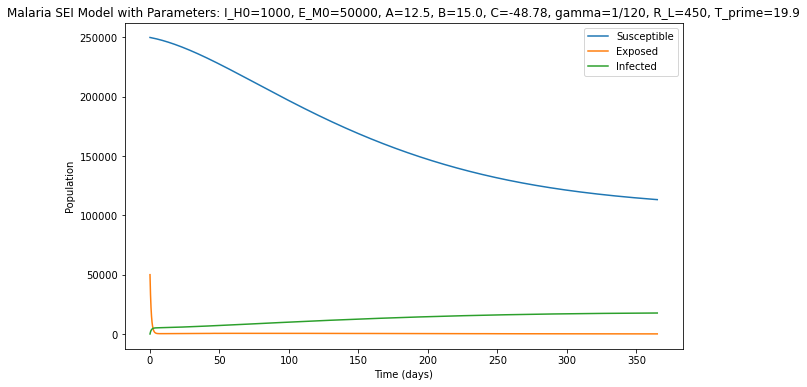

In [40]:
t_eval = np.linspace(0, 365, 1000)  # Evaluate the solution at 1000 points between 0 and 365
sol = solve_ivp(b3_correction_model, [0, 365], [S_H0, I_H0, 0, S_M0, E_M0, 0], args=args, dense_output=True, t_eval=t_eval, method="DOP853")
#sol

times = sol.t
S_H, I_H, R_H, S_M, E_M, I_M = sol.y

plt.figure(figsize=(10, 6))
plt.plot(times, S_M, label='Susceptible')
plt.plot(times, E_M, label='Exposed')
plt.plot(times, I_M, label='Infected')

plt.xlabel('Time (days)')
plt.ylabel('Population')
plt.title(f'Malaria SEI Model with Parameters: I_H0={I_H0}, E_M0={E_M0}, A={round(A, 2)}, B={round(B, 2)}, C={round(C, 2)}, gamma={gamma}, R_L={R_L}, T_prime={round(T_prime, 2)}')

plt.legend()

plt.show()

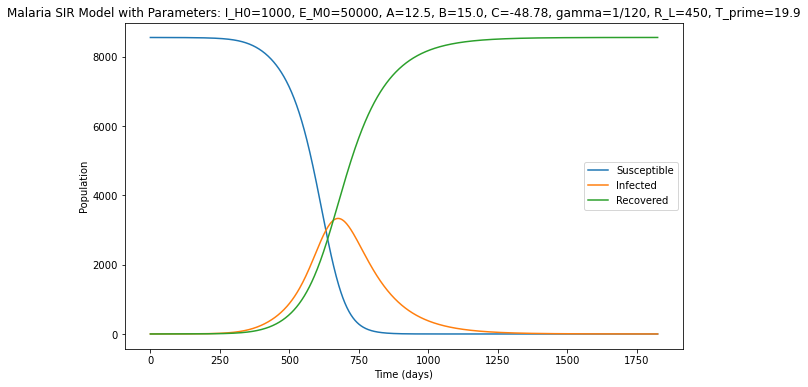

In [41]:
t_eval = np.linspace(0, 1825, 1000)  # Evaluate the solution at 1000 points between 0 and 1825
sol = solve_ivp(b3_correction_model, [0, 1825], [N-1, 1, 0, M-1, 1, 0], args=args, dense_output=True, t_eval=t_eval, method="DOP853")
#sol

times = sol.t
S_H, I_H, R_H, S_M, E_M, I_M = sol.y

plt.figure(figsize=(10, 6))
plt.plot(times, S_H, label='Susceptible')
plt.plot(times, I_H, label='Infected')
plt.plot(times, R_H, label='Recovered')

plt.xlabel('Time (days)')
plt.ylabel('Population')
plt.title(f'Malaria SIR Model with Parameters: I_H0={I_H0}, E_M0={E_M0}, A={round(A, 2)}, B={round(B, 2)}, C={round(C, 2)}, gamma={gamma}, R_L={R_L}, T_prime={round(T_prime, 2)}')

plt.legend()

plt.show()

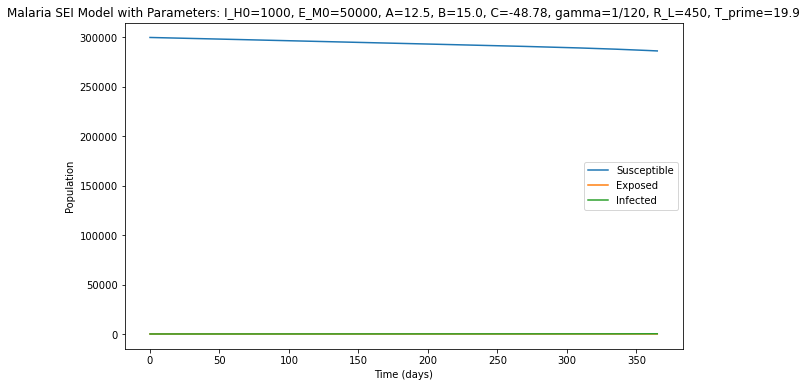

In [42]:
t_eval = np.linspace(0, 365, 1000)  # Evaluate the solution at 1000 points between 0 and 365
sol = solve_ivp(b3_correction_model, [0, 365], [N-1, 1, 0, M-1, 1, 0], args=args, dense_output=True, t_eval=t_eval, method="DOP853")
#sol

times = sol.t
S_H, I_H, R_H, S_M, E_M, I_M = sol.y

plt.figure(figsize=(10, 6))
plt.plot(times, S_M, label='Susceptible')
plt.plot(times, E_M, label='Exposed')
plt.plot(times, I_M, label='Infected')

plt.xlabel('Time (days)')
plt.ylabel('Population')
plt.title(f'Malaria SEI Model with Parameters: I_H0={I_H0}, E_M0={E_M0}, A={round(A, 2)}, B={round(B, 2)}, C={round(C, 2)}, gamma={gamma}, R_L={R_L}, T_prime={round(T_prime, 2)}')

plt.legend()

plt.show()

#### Calculating $\mathcal{R}_0$ for the original parameters from Parham & Michael:

In [43]:
T_prime=19.9

T1=23.2
T2=0.07
omega1=0.67
phi1=1.53

R1=85.9
R2=0.98
omega2=0.65
phi2=1.99

B_E=200
p_ME=0.9
p_ML=0.25
p_MP=0.75
tau_E=1
tau_P=1
c1=0.00554
c2=-0.06737
D1=36.5
b1=0.04
A=-0.03
B=1.31
C=-4.4
b2=0.09
tau_H=10
DD=105
Tmin=14.5
gamma= 1/120
R_L = 50
M=300000  #0

E_M0=50000
I_M0=0 # None
I_H0=1000

if E_M0 is None:
        E_M0 = M / 100

S_H0 = N - I_H0
S_M0 = M - E_M0 - I_M0

#### Using $T'$ as the value of $T_1$ defined for the temperature function:

In [44]:
initial_R0_sir, initial_R0_sei, initial_R0_full = calculate_initial_values(R_L, T1, Tmin, DD, D1, 
                                                                           T1, T2, omega1, phi1, R1, R2, omega2, phi2,
                                                                           p_ML, p_ME, p_MP, c1, c2, A, B, C, b1, b2, gamma)

In [45]:
print(f'R0 (SIR) = {initial_R0_sir} \nR0 (SEI) = {initial_R0_sei}\nR0 (Full) = {initial_R0_full}')

R0 (SIR) = 0.01959825942927436 
R0 (SEI) = 0.00012392848185565277
R0 (Full) = 0.0015584551767963053


#### Using $T'$ as the value of $T_1$ defined separately as $19.9^{\circ}C$ in the article:

In [46]:
initial_R0_sir, initial_R0_sei, initial_R0_full = calculate_initial_values(R_L, T_prime, Tmin, DD, D1, 
                                                                           T1, T2, omega1, phi1, R1, R2, omega2, phi2,
                                                                           p_ML, p_ME, p_MP, c1, c2, A, B, C, b1, b2, gamma)

In [47]:
print(f'R0 (SIR) = {initial_R0_sir} \nR0 (SEI) = {initial_R0_sei}\nR0 (Full) = {initial_R0_full}')

R0 (SIR) = 0.9960366155936582 
R0 (SEI) = 0.006298381041878821
R0 (Full) = 0.07920491232664953
